In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import scipy.io as sio

import copy

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [3]:
data = sio.loadmat("lssd_pca_118.mat")

names = [name[0][0] for name in data['names']]
names_df = pd.DataFrame([name.split('_') for name in names], columns=['Genus', 'Catalog_No', '1','2']).iloc[:,:2]
names_df['ID'] = names

hominoids = pd.read_csv('hominoid_procrustes_coordinates.csv')
hominoids = hominoids[hominoids['ID'].isin(names)]
new_names = hominoids[hominoids['ID'].isin(names)]['ID']
hominoids = hominoids.set_index('ID')

hominoid_landmarks = pd.read_csv('Cuboid_21L_coords.csv')
hominoid_landmarks = hominoid_landmarks[hominoid_landmarks['ID'].isin(new_names)]
hominoid_landmarks = hominoid_landmarks.set_index('ID')

auto3dgm = pd.read_csv('auto3dgm_procrustes_coordinates_12K_512.csv')
auto3dgm = auto3dgm[auto3dgm['ID'].isin(new_names)]
auto3dgm = auto3dgm.set_index('ID')

area_lssds = pd.concat([names_df, pd.DataFrame(data['area_based'][:,:4900], columns=['L' + str(j) for j in list(range(1,4901))])], axis=1)
area_lssds = area_lssds[area_lssds['ID'].isin(new_names)]
area_lssds = area_lssds.set_index('ID')

conf_lssds = pd.concat([names_df, pd.DataFrame(data['conf_based'][:,:4900], columns=['L' + str(j) for j in list(range(1,4901))])], axis=1)
conf_lssds = conf_lssds[conf_lssds['ID'].isin(new_names)]
conf_lssds = conf_lssds.set_index('ID')

auto3dgm_y = auto3dgm['Genus']
hominoid_y = hominoids['Genus']
hominoid_landmarks_y = hominoid_landmarks['Genus']
area_lssds_y = area_lssds['Genus']
conf_lssds_y = conf_lssds['Genus']

conf_area_lssds = pd.concat([conf_lssds,area_lssds], axis=1)
conf_area_lssds_y = area_lssds['Genus']

del area_lssds['Genus']
del area_lssds['Catalog_No']
del conf_area_lssds['Genus']
del conf_area_lssds['Catalog_No']
del conf_lssds['Genus']
del conf_lssds['Catalog_No']
del auto3dgm['Genus']
del hominoids['Genus']
del hominoid_landmarks['Genus']

In [4]:
scaler_area = StandardScaler()
scaler_conf = StandardScaler()
scaler_auto = StandardScaler()
scaler_coords = StandardScaler()
scaler_coords2 = StandardScaler()

scalar_conf_area = StandardScaler()

X_conf_area_scaled = scalar_conf_area.fit_transform(np.array(conf_area_lssds))


X_area_scaled = scaler_area.fit_transform(np.array(area_lssds))
X_conf_scaled = scaler_conf.fit_transform(np.array(conf_lssds))
X_auto_scaled = scaler_area.fit_transform(np.array(auto3dgm))
X_coords_scaled = scaler_coords.fit_transform(np.array(hominoids))
X_coords2_scaled = scaler_coords2.fit_transform(np.array(hominoid_landmarks))

In [5]:
pca_coords = PCA()
pca_coords.fit(X_coords_scaled)

X_coords = pca_coords.transform(X_coords_scaled)
X_coords_pcs = pd.DataFrame(X_coords[:, :27],
                          columns=['PC' + str(j) for j in list(range(1,27+1))],
                         index=hominoids.index)
X_coords_pcs['Genus'] = hominoid_y
X_coords_pcs.Genus = pd.Categorical(X_coords_pcs.Genus)
X_coords_pcs['Group'] = X_coords_pcs.Genus.cat.codes
y_coords_labels = list(X_coords_pcs['Genus'])
y_coords = np.array(X_coords_pcs['Group'])

pca_coords2 = PCA()
pca_coords2.fit(X_coords2_scaled)
X_coords2 = pca_coords2.transform(X_coords2_scaled)
X_coords2_pcs = pd.DataFrame(X_coords2[:, :27],
                          columns=['PC' + str(j) for j in list(range(1,27+1))],
                         index=hominoid_landmarks.index)
X_coords2_pcs['Genus'] = hominoid_landmarks_y
X_coords2_pcs.Genus = pd.Categorical(X_coords2_pcs.Genus)
X_coords2_pcs['Group'] = X_coords2_pcs.Genus.cat.codes
y_coords2_labels = list(X_coords2_pcs['Genus'])
y_coords2 = np.array(X_coords2_pcs['Group'])

pca_auto = PCA()
pca_auto.fit(X_auto_scaled)
X_auto = pca_auto.transform(X_auto_scaled)
X_auto_pcs = pd.DataFrame(X_auto[:, :64],
                          columns=['PC' + str(j) for j in list(range(1,64+1))],
                         index=auto3dgm.index)
X_auto_pcs['Genus'] = auto3dgm_y
X_auto_pcs.Genus = pd.Categorical(X_auto_pcs.Genus)
X_auto_pcs['Group'] = X_auto_pcs.Genus.cat.codes
y_auto_labels = list(X_auto_pcs['Genus'])
y_auto = np.array(X_auto_pcs['Group'])

pca_area = PCA()
pca_area.fit(X_area_scaled)
X_area = pca_area.transform(X_area_scaled)
X_area_pcs = pd.DataFrame(X_area[:,:60],
                          columns=['PC' + str(j) for j in list(range(1,60+1))],
                         index=area_lssds.index)
X_area_pcs['Genus'] = area_lssds_y
X_area_pcs.Genus = pd.Categorical(X_area_pcs.Genus)
X_area_pcs['Group'] = X_area_pcs.Genus.cat.codes
y_area_labels = list(X_area_pcs['Genus'])
y_area = np.array(X_area_pcs['Group'])

pca_conf = PCA()
pca_conf.fit(X_conf_scaled)
X_conf = pca_conf.transform(X_conf_scaled)
X_conf_pcs = pd.DataFrame(X_conf[:, :59],
                          columns=['PC' + str(j) for j in list(range(1,59+1))],
                         index=conf_lssds.index)
X_conf_pcs['Genus'] = conf_lssds_y
X_conf_pcs.Genus = pd.Categorical(X_conf_pcs.Genus)
X_conf_pcs['Group'] = X_conf_pcs.Genus.cat.codes
y_conf_labels = list(X_conf_pcs['Genus'])
y_conf = np.array(X_conf_pcs['Group'])

pca_conf_area = PCA()
pca_conf_area.fit(X_conf_area_scaled)
X_conf_area = pca_conf_area.transform(X_conf_area_scaled)
X_conf_area_pcs = pd.DataFrame(X_conf_area[:,:64],
                          columns=['PC' + str(j) for j in list(range(1,64+1))],
                         index=conf_area_lssds.index)
X_conf_area_pcs['Genus'] = conf_area_lssds_y
X_conf_area_pcs.Genus = pd.Categorical(X_conf_area_pcs.Genus)
X_conf_area_pcs['Group'] = X_conf_area_pcs.Genus.cat.codes
y_conf_area_labels = list(X_conf_area_pcs['Genus'])
y_conf_area = np.array(X_conf_area_pcs['Group'])

In [6]:
[float(i)*100 for i in pca_area.explained_variance_ratio_[0:4]]

[16.22357861534604, 13.154779823336757, 7.144706664817085, 5.2384283307485395]

In [7]:
[float(i)*100 for i in pca_conf.explained_variance_ratio_[0:4]]

[21.823467475891576, 15.85473945827853, 7.671241021514845, 5.217763426152885]

(0.0, 0.4)

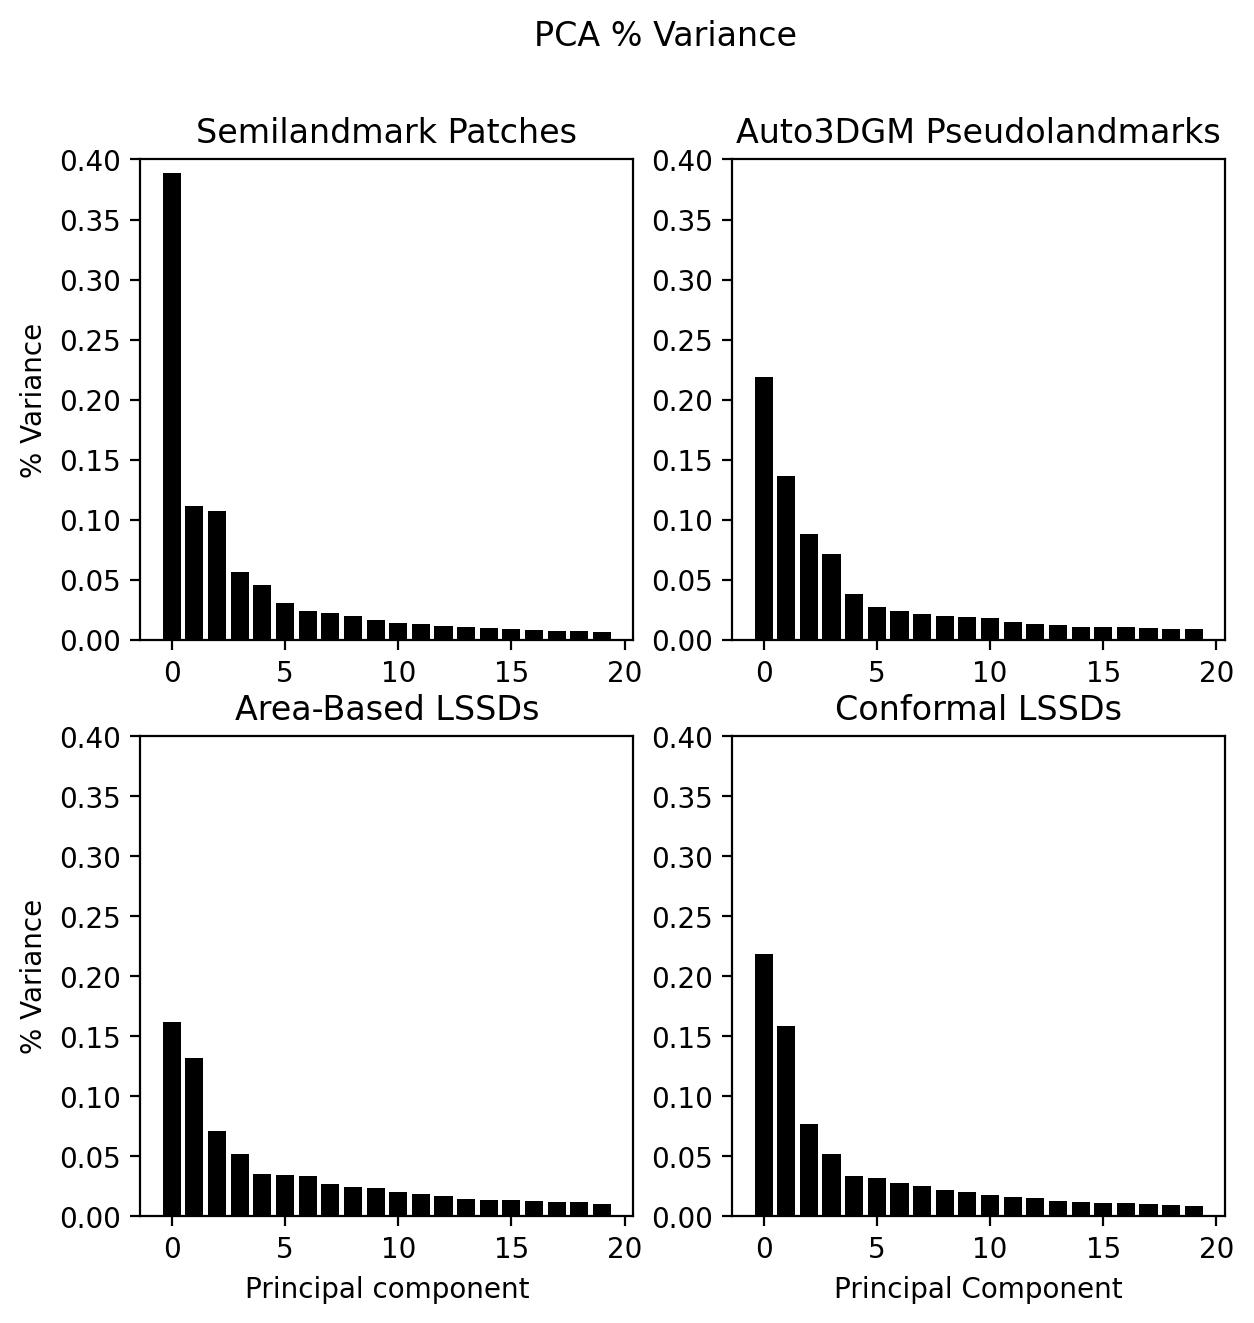

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(7,7), dpi=200)
fig.suptitle('PCA % Variance')

features = range(20)
axs[0, 0].bar(features, pca_coords.explained_variance_ratio_[:20], color='black')
axs[0, 0].set_title('Semilandmark Patches')
axs[0, 0].set_ylim(0,0.4)
axs[0, 0].set_ylabel('% Variance')
axs[0, 1].bar(features, pca_auto.explained_variance_ratio_[:20], color='black')
axs[0, 1].set_ylim(0,0.4)
axs[0, 1].set_title('Auto3DGM Pseudolandmarks')
axs[1, 0].bar(features, pca_area.explained_variance_ratio_[:20], color='black')
axs[1, 0].set_title('Area-Based LSSDs')
axs[1, 0].set_ylabel('% Variance')
axs[1, 0].set_ylim(0,0.4)
axs[1, 0].set_xlabel('Principal component')
axs[1, 1].bar(features, pca_conf.explained_variance_ratio_[:20], color='black')
axs[1, 1].set_title('Conformal LSSDs')
axs[1, 1].set_xlabel('Principal Component')
axs[1, 1].set_ylim(0,0.4)


In [ ]:
sum_of_squared_distances_coords = []

K_coords = range(1,27)
for k in K_coords:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(X_coords[:, :27])
    sum_of_squared_distances_coords.append(np.sqrt(k_means.inertia_/27))

sum_of_squared_distances_auto = []

K_auto = range(1,64)
for k in K_auto:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(X_auto[:, :64])
    sum_of_squared_distances_auto.append(np.sqrt(k_means.inertia_/52))

sum_of_squared_distances_area = []

K_area = range(1,60)
for k in K_area:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(X_area[:,:60])
    sum_of_squared_distances_area.append(np.sqrt(k_means.inertia_/60))
    
sum_of_squared_distances_conf = []

K_conf = range(1,59)
for k in K_conf:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(X_conf[:, :59])
    sum_of_squared_distances_conf.append(np.sqrt(k_means.inertia_/59))
    
sum_of_squared_distances_conf_area = []

K_conf_area = range(1,64)
for k in K_conf_area:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(X_conf_area[:, :64])
    sum_of_squared_distances_conf_area.append(np.sqrt(k_means.inertia_/64))

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(7,7), dpi=200)
fig.suptitle('Elbow Method for Optimal k')

features = range(20)
axs[0, 0].set_title('Semilandmark Patches')
axs[0, 0].plot(K_coords, sum_of_squared_distances_coords, 'bx-')
axs[0, 0].set_ylabel('Inertia*')
axs[0, 0].scatter(5, sum_of_squared_distances_coords[4], color='r', s=60)
axs[0, 1].set_title('Auto3DGM Pseudolandmarks')
axs[0, 1].plot(K_auto, sum_of_squared_distances_auto, 'bx-')
axs[0, 1].scatter(5, sum_of_squared_distances_auto[4], color='r', s=60)
axs[1, 0].plot(K_area, sum_of_squared_distances_area, 'bx-')
axs[1, 0].scatter(5, sum_of_squared_distances_area[4], color='r', s=60)
axs[1, 0].set_title('Area-Based LSSDs')
axs[1, 0].set_ylabel('Inertia*')
axs[1, 0].set_xlabel('k')
axs[1, 1].plot(K_conf, sum_of_squared_distances_conf, 'bx-')
axs[1, 1].scatter(5, sum_of_squared_distances_conf[4], color='r', s=60)
axs[1, 1].set_title('Conformal LSSDs')
axs[1, 1].set_xlabel('k')

In [51]:
k_means = KMeans(n_clusters=5, random_state=0)
model_coords = k_means.fit(X_coords[:, :27], y_coords)
k_means.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 2, 2,
       0, 2, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 2, 0, 1, 2, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1])

In [52]:
y_coords

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int8)

In [53]:
re_labels_ = k_means.labels_

for i in range(y_coords.shape[0]):
    if re_labels_[i] == 0:
        re_labels_[i] = 0
    elif re_labels_[i] == 1:
        re_labels_[i] = 4
    elif re_labels_[i] == 2:
        re_labels_[i] = 3
    elif re_labels_[i] == 3:
        re_labels_[i] = 2
    else:
        re_labels_[i] = 1
re_labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 3, 3,
       0, 3, 0, 3, 3, 0, 0, 4, 0, 0, 0, 0, 3, 4, 0, 3, 0, 4, 3, 4, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4])

In [54]:
print(classification_report(y_coords,
                            re_labels_,
                            target_names=['Gorilla', 'Homo', 'Hylobates', 'Pan', 'Pongo']))

              precision    recall  f1-score   support

     Gorilla       0.50      1.00      0.67        11
        Homo       1.00      1.00      1.00        34
   Hylobates       1.00      1.00      1.00        18
         Pan       0.70      0.35      0.47        20
       Pongo       0.89      0.84      0.86        19

    accuracy                           0.84       102
   macro avg       0.82      0.84      0.80       102
weighted avg       0.87      0.84      0.83       102



In [55]:
precision_recall_fscore_support(y_coords, re_labels_, average='weighted')

(0.866557734204793, 0.8431372549019608, 0.8343048931284226, None)

In [56]:
k_means = KMeans(n_clusters=5, random_state=0)
model_coords = k_means.fit(X_coords2[:, :27], y_coords2)
k_means.labels_

array([1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4,
       4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [57]:
y_coords2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
       4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int8)

In [58]:
re_labels_ = k_means.labels_

for i in range(y_coords.shape[0]):
    if re_labels_[i] == 3:
        re_labels_[i] = 0
    elif re_labels_[i] == 0:
        re_labels_[i] = 1
    elif re_labels_[i] == 2:
        re_labels_[i] = 2
    elif re_labels_[i] == 1:
        re_labels_[i] = 3
    else:
        re_labels_[i] = 4

In [59]:
re_labels_

array([3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
       4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [60]:
print(classification_report(y_coords2,
                            re_labels_,
                            target_names=['Gorilla', 'Homo', 'Hylobates', 'Pan', 'Pongo']))

              precision    recall  f1-score   support

     Gorilla       1.00      0.91      0.95        11
        Homo       1.00      1.00      1.00        34
   Hylobates       1.00      1.00      1.00        18
         Pan       0.95      1.00      0.98        20
       Pongo       1.00      1.00      1.00        19

    accuracy                           0.99       102
   macro avg       0.99      0.98      0.99       102
weighted avg       0.99      0.99      0.99       102



In [61]:
precision_recall_fscore_support(y_coords2, re_labels_, average='weighted')

(0.9906629318394025, 0.9901960784313726, 0.9900822117464871, None)

In [62]:
k_means = KMeans(n_clusters=5, random_state=0)
model_auto = k_means.fit(X_auto[:, :64], y_auto)
k_means.labels_

array([3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 3,
       0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 3, 4, 3, 0, 1])

In [63]:
y_auto

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int8)

In [64]:
re_labels_ = copy.deepcopy(k_means.labels_)

for i in range(y_auto.shape[0]):
    if re_labels_[i] == 0:
        re_labels_[i] = 3
    elif re_labels_[i] == 1:
        re_labels_[i] = 4
    elif re_labels_[i] == 2:
        re_labels_[i] = 2
    elif re_labels_[i] == 3:
        re_labels_[i] = 0
    else:
        re_labels_[i] = 1

In [65]:
re_labels_

array([0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 0,
       3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 4, 1, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 3, 4, 0, 1, 0, 3, 4])

In [66]:
print(classification_report(y_auto,
                            re_labels_,
                            target_names=['Gorilla', 'Homo', 'Hylobates', 'Pan', 'Pongo']))

              precision    recall  f1-score   support

     Gorilla       0.64      0.82      0.72        11
        Homo       0.94      1.00      0.97        34
   Hylobates       1.00      1.00      1.00        18
         Pan       0.81      0.85      0.83        20
       Pongo       1.00      0.68      0.81        19

    accuracy                           0.89       102
   macro avg       0.88      0.87      0.87       102
weighted avg       0.91      0.89      0.89       102



In [69]:
precision_recall_fscore_support(y_auto, re_labels_, average='weighted')

(0.9056178026766262, 0.8921568627450981, 0.8918768361002938, None)

In [75]:
k_means = KMeans(n_clusters=5, random_state=0)
model_coords = k_means.fit(X_area[:,:60], y_area)
k_means.labels_

array([2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 2, 3, 3])

In [76]:
y_area

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int8)

In [77]:
re_labels_ = copy.deepcopy(k_means.labels_)

for i in range(y_auto.shape[0]):
    if re_labels_[i] == 0:
        re_labels_[i] = 2
    elif re_labels_[i] == 1:
        re_labels_[i] = 3
    elif re_labels_[i] == 2:
        re_labels_[i] = 0
    elif re_labels_[i] == 3:
        re_labels_[i] = 4
    else:
        re_labels_[i] = 1

In [78]:
re_labels_

array([0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 0, 4, 4])

In [79]:
print(classification_report(y_area,
                            re_labels_,
                            target_names=['Gorilla', 'Homo', 'Hylobates', 'Pan', 'Pongo']))

              precision    recall  f1-score   support

     Gorilla       0.88      0.64      0.74        11
        Homo       1.00      0.97      0.99        34
   Hylobates       0.89      0.94      0.92        18
         Pan       0.83      1.00      0.91        20
       Pongo       0.94      0.89      0.92        19

    accuracy                           0.92       102
   macro avg       0.91      0.89      0.89       102
weighted avg       0.92      0.92      0.92       102



In [80]:
precision_recall_fscore_support(y_area, re_labels_, average='weighted')

(0.9249154340098613, 0.9215686274509803, 0.9194080260112328, None)

In [86]:
k_means = KMeans(n_clusters=5, random_state=0)
model_coords = k_means.fit(X_conf[:,:59], y_area)
k_means.labels_

array([2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1])

In [87]:
y_conf

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int8)

In [88]:
re_labels_ = copy.deepcopy(k_means.labels_)

for i in range(y_auto.shape[0]):
    if re_labels_[i] == 0:
        re_labels_[i] = 3
    elif re_labels_[i] == 1:
        re_labels_[i] = 4
    elif re_labels_[i] == 2:
        re_labels_[i] = 0
    elif re_labels_[i] == 3:
        re_labels_[i] = 2
    else:
        re_labels_[i] = 1

In [89]:
re_labels_

array([0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4])

In [90]:
print(classification_report(y_conf,
                            re_labels_,
                            target_names=['Gorilla', 'Homo', 'Hylobates', 'Pan', 'Pongo']))

              precision    recall  f1-score   support

     Gorilla       1.00      0.82      0.90        11
        Homo       1.00      0.97      0.99        34
   Hylobates       0.94      0.94      0.94        18
         Pan       0.87      1.00      0.93        20
       Pongo       0.95      0.95      0.95        19

    accuracy                           0.95       102
   macro avg       0.95      0.94      0.94       102
weighted avg       0.95      0.95      0.95       102



In [91]:
precision_recall_fscore_support(y_conf, re_labels_, average='weighted')

(0.9548167092924127, 0.9509803921568627, 0.9509528281982699, None)

In [93]:
k_means = KMeans(n_clusters=5, random_state=0)
model_coords = k_means.fit(X_conf_area[:,:64], y_conf_area)
k_means.labels_

array([1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 0, 3, 3])

In [94]:
y_conf_area

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int8)

In [95]:
re_labels_ = copy.deepcopy(k_means.labels_)

for i in range(y_auto.shape[0]):
    if re_labels_[i] == 0:
        re_labels_[i] = 3
    elif re_labels_[i] == 1:
        re_labels_[i] = 0
    elif re_labels_[i] == 2:
        re_labels_[i] = 1
    elif re_labels_[i] == 3:
        re_labels_[i] = 4
    else:
        re_labels_[i] = 2

In [96]:
print(classification_report(y_conf_area,
                            re_labels_,
                            target_names=['Gorilla', 'Homo', 'Hylobates', 'Pan', 'Pongo']))

              precision    recall  f1-score   support

     Gorilla       1.00      0.73      0.84        11
        Homo       0.97      0.97      0.97        34
   Hylobates       0.94      0.94      0.94        18
         Pan       0.83      1.00      0.91        20
       Pongo       0.94      0.89      0.92        19

    accuracy                           0.93       102
   macro avg       0.94      0.91      0.92       102
weighted avg       0.94      0.93      0.93       102



In [97]:
precision_recall_fscore_support(y_conf_area, re_labels_, average='weighted')

(0.937363834422658, 0.9313725490196079, 0.9304356425099459, None)